### IMF API

August 28, 2017<br>
Brian Dew

--- 

Clean example.

In [444]:
import requests
import pandas as pd

url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
notes_dims = 'DataStructure/IFS'  # Method / series

#### About IFS

In [445]:
r = requests.get('{}{}'.format(url, notes_dims)).json()\
    ['Structure']['KeyFamilies']['KeyFamily']

In [446]:
notes = r['Annotations']['Annotation']
dimensions = r['Components']['Dimension']
print 'Notes\n'
for note in notes:
    print u'{}: {}\n'.format(note['AnnotationTitle'], 
                             note['AnnotationText']['#text'])
print '\nDimension List \n '
for n, dimension in enumerate(dimensions):
    print 'Dimension {}: {}'.format(n+1, dimension['@codelist'])

Notes

Latest Update Date: 08/26/2017

Name: International Financial Statistics (IFS)

Temporal Coverage: Data available starting in the 1948 for many IMF member countries. Varies by country.

Geographic Coverage: IFS covers 194 countries and areas.

Under the Fund’s legal framework, the member in effective control of a territory must report data respecting that territory. With respect to data on any territory whose status is the subject of a dispute between members, the IMF’s use of data on that territory provided by a member, either for surveillance or any other Fund activities, does not constitute a judgment by the IMF on the status of that territory.

Methodology: The International Financial Statistics is based on various IMF data collections. It includes exchange rates series for all Fund member countries plus Anguilla, Aruba, China, P.R.: Hong Kong, China, P.R.: Macao, Montserrat, and the Netherlands Antilles. It also includes major Fund accounts series, real effective exchange r

#### Get series name

In [462]:
search_term = 'Interest'  # Term to find in series names
dim_codes = 'CodeList/CL_INDICATOR_IFS'
code_list = requests.get('{}{}'.format(url, dim_codes)).json()\
            ['Structure']['CodeLists']['CodeList']['Code']

for code in code_list:
    if search_term in code['Description']['#text']:
        print '{}: {}'.format(code['Description']['#text'], 
                              code['@value'])

Financial, Interest Rates Government Bond Yield, Per Cent Per Annum: FIGBY_PA
Financial, Interest Rates, Central Bank Borrowing Facility Rate: FIBFR_PA
Financial, Interest Rates, Central Bank Certificates: FICB_PA
Financial, Interest Rates, Corporate Paper Rate: FICPR_PA
Financial, Interest Rates, Deposit, Foreign Currency, Percent per Annum: FIDR_FX_PA
Financial, Interest Rates, Deposit, Overnight: FIDR_ON_PA
Financial, Interest Rates, Deposit, Percent per annum: FIDR_PA
Financial, Interest Rates, Discount, Foreign Currency: FID_FX_PA
Financial, Interest Rates, Discount, Percent per annum: FID_PA
Financial, Interest Rates, Eurosystem Deposit Facility Rate: FIDFR_PA
Financial, Interest Rates, Government Bond Yields, Short- to Medium-Term: FIGBY_SM_PA
Financial, Interest Rates, Government Securities, Government Bonds, Medium- to Long-term, Percent per annum: FIGB_MLT_PA
Financial, Interest Rates, Government Securities, Government Bonds, Percent per annum: FIGB_PA
Financial, Interest Rat

#### Get series data

In [497]:
d1 = 'A'
d2 = '+'.join(['GB', 'US'])
d3 = '+'.join(['PMP_IX', 'FPOLM_PA'])

cd = 'CompactData/'
md = 'GenericMetadata/'
s = '/IFS/{}.{}.{}'.format(d1, d2, d3)

In [498]:
r = requests.get('{}{}{}{}'.format(url, cd, s, dates)).json()\
        ['CompactData']['DataSet']['Series']
r2 = requests.get('{}{}{}{}'.format(url, md, s, dates)).json()\
        ['GenericMetadata']['MetadataSet']['AttributeValueSet']
    
cd = {s['ReportedAttribute'][1]['ReportedAttribute']\
      [4]['Value']['#text']: s['ReportedAttribute'][1]\
      ['ReportedAttribute'][0]['Value']['#text'] for s in r2 
      if 'REF_AREA' in s['ReportedAttribute'][1]['@conceptID']}

In [499]:
d = {'{} {}'.format(cd[s['@REF_AREA']], s['@INDICATOR']):\
      pd.DataFrame(s['Obs'])
     .set_index('@TIME_PERIOD')['@OBS_VALUE']
     .astype(float) for s in r}
df = pd.concat(d, axis=1).reset_index()  
df = df.set_index(pd.to_datetime(df['index']))\
        .dropna().drop('index', 1)

In [500]:
df['p diff'] = df['United Kingdom PMP_IX'].pct_change() * 100\
                - df['United States PMP_IX'].pct_change() * 100
                

df['i diff'] = (df['United Kingdom FPOLM_PA'])\
                - (df['United States FPOLM_PA'])

#### Show results

In [501]:
df.describe()

,United Kingdom FPOLM_PA,United Kingdom PMP_IX,United States FPOLM_PA,United States PMP_IX,p diff,i diff
count,35.000000,35.000000,35.000000,35.000000,34.000000,35.000000
mean,5.832143,81.024938,4.024160,82.358541,0.752032,1.807983
std,4.145359,14.339666,3.047742,14.771854,4.911958,2.027768
min,0.250000,54.401865,0.125000,62.043326,-6.167941,-0.500000
25%,2.875000,70.867892,0.812500,73.749589,-2.314612,0.375000
50%,5.500000,78.789672,4.250000,76.385146,-0.383595,1.370000
75%,8.718750,89.792520,6.190000,94.028919,2.299048,2.625000
max,14.875000,108.662668,9.380000,111.212619,13.664075,6.875000


In [502]:
df.head(2)

,United Kingdom FPOLM_PA,United Kingdom PMP_IX,United States FPOLM_PA,United States PMP_IX,p diff,i diff
index,,,,,,
1982-01-01,10.0000,54.401865,8.50,67.482189,NaN,1.5000
1983-01-01,9.0625,59.270960,9.38,64.702326,13.069638,-0.3175


In [503]:
df.tail(10)

,United Kingdom FPOLM_PA,United Kingdom PMP_IX,United States FPOLM_PA,United States PMP_IX,p diff,i diff
index,,,,,,
2007-01-01,5.50,81.015085,4.250,94.814328,-4.239613,1.250
2008-01-01,2.00,92.574381,0.125,105.724614,2.761078,1.875
2009-01-01,0.50,94.582882,0.125,93.572133,13.664075,0.375
2010-01-01,0.50,100.000000,0.125,100.000000,-1.142048,0.375
2011-01-01,0.50,108.442131,0.125,110.903713,-2.461582,0.375
2012-01-01,0.50,108.662668,0.125,111.212619,-0.075167,0.375
2013-01-01,0.50,105.848624,0.125,109.990141,-1.490480,0.375
2014-01-01,0.50,104.348977,0.125,108.807098,-0.341195,0.375
2015-01-01,0.50,99.867678,0.375,97.739073,5.877623,0.125


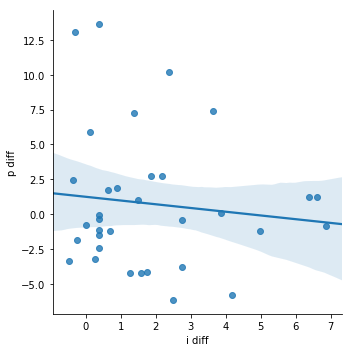

In [504]:
import seaborn as sns
sns.lmplot(x='i diff', y='p diff', data=df, fit_reg=True)

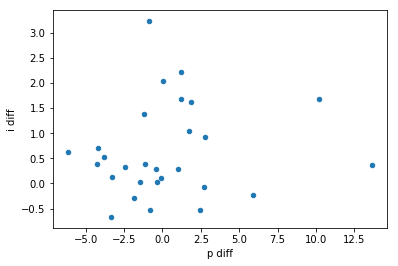

In [435]:
df.plot.scatter(x='p diff', y='i diff')

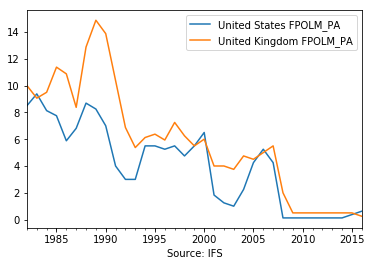

In [505]:
%matplotlib inline
ax = df[['United States FPOLM_PA', 'United Kingdom FPOLM_PA']].plot()
ax.set_xlabel('Source: IFS')

In [325]:
key = 'CompactData/IFS/A.GB.PMP_IX' # adjust codes here
data = requests.get('{}{}'.format(url,key)).json()
data['CompactData']['DataSet']['Series']['Obs'][0]

{u'@OBS_VALUE': u'8.40037097273409', u'@TIME_PERIOD': u'1963'}

In [320]:
data['CompactData']['DataSet']['Series']['@BASE_YEAR']

u'2010A1'

In [393]:
s

'/IFS/A.GB+US.PMP_IX+FIGB_PA'

In [389]:
cd

{u'GB': u'United Kingdom', u'US': u'United States'}

In [394]:
s['@INDICATOR']

[{u'@FREQ': u'A',
  u'@INDICATOR': u'FIGB_PA',
  u'@REF_AREA': u'GB',
  u'@TIME_FORMAT': u'P1Y',
  u'@UNIT_MULT': u'0',
  u'Obs': [{u'@OBS_VALUE': u'5.429999999', u'@TIME_PERIOD': u'1963'},
   {u'@OBS_VALUE': u'5.979999999', u'@TIME_PERIOD': u'1964'},
   {u'@OBS_VALUE': u'6.559999999', u'@TIME_PERIOD': u'1965'},
   {u'@OBS_VALUE': u'6.939999999', u'@TIME_PERIOD': u'1966'},
   {u'@OBS_VALUE': u'6.799999999', u'@TIME_PERIOD': u'1967'},
   {u'@OBS_VALUE': u'7.549999999', u'@TIME_PERIOD': u'1968'},
   {u'@OBS_VALUE': u'9.04', u'@TIME_PERIOD': u'1969'},
   {u'@OBS_VALUE': u'9.22', u'@TIME_PERIOD': u'1970'},
   {u'@OBS_VALUE': u'8.90416666666666', u'@TIME_PERIOD': u'1971'},
   {u'@OBS_VALUE': u'8.9025', u'@TIME_PERIOD': u'1972'},
   {u'@OBS_VALUE': u'10.7125', u'@TIME_PERIOD': u'1973'},
   {u'@OBS_VALUE': u'14.7658333333333', u'@TIME_PERIOD': u'1974'},
   {u'@OBS_VALUE': u'14.3925', u'@TIME_PERIOD': u'1975'},
   {u'@OBS_VALUE': u'14.43', u'@TIME_PERIOD': u'1976'},
   {u'@OBS_VALUE': u'12.725

In [443]:
df

,United Kingdom FIGB_PA,United Kingdom PCPI_IX,United Kingdom PMP_IX,United States FIGB_PA,United States PCPI_IX,United States PMP_IX,p diff,i diff
index,,,,,,,,
1988-01-01,9.675833,55.456068,65.985328,8.845833,54.233135,69.768526,NaN,NaN
1989-01-01,10.190833,58.360632,68.800378,8.499167,56.850970,71.885917,1.231297,1.687561
1990-01-01,11.802500,62.429934,70.436879,8.550000,59.919760,74.214043,-0.860019,3.236753
1991-01-01,10.105000,67.132562,71.298904,7.858333,62.457341,74.214043,1.223826,2.213690
1992-01-01,9.063333,69.993448,71.898281,7.010000,64.349061,74.807756,0.040654,2.041006
1993-01-01,7.550442,71.747834,79.090803,5.873333,66.248425,74.636872,10.232178,1.681560
1994-01-01,8.122100,73.167358,81.777897,7.080000,67.975813,75.892212,1.715549,1.048390
1995-01-01,8.200283,75.111014,87.010658,6.580000,69.882820,79.316464,1.886754,1.621773
1996-01-01,7.810183,76.974594,86.862498,6.438333,71.931229,80.118304,-1.181217,1.376351


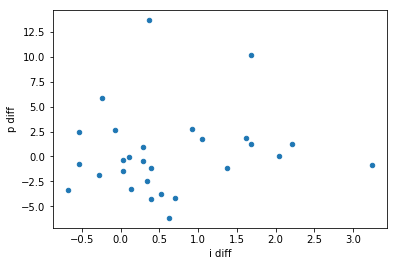

In [442]:
df.plot.scatter(x='i diff', y='p diff')

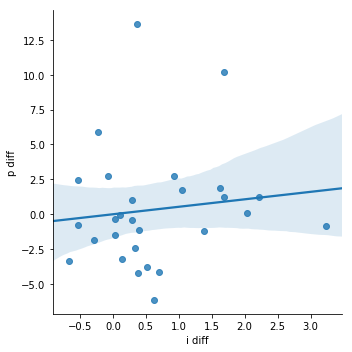

In [441]:
import seaborn as sns
sns.lmplot(x='i diff', y='p diff', data=df, fit_reg=True)